In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from transformers import pipeline                 # Chapter 4: Classification
from sentence_transformers import SentenceTransformer # Chapter 5: Embeddings
from umap import UMAP                                       # Chapter 5: Dim Reduction
from hdbscan import HDBSCAN

In [3]:
data = pd.read_csv("1429_1.csv" , low_memory=False)

In [4]:
df  =pd.DataFrame(data)

In [5]:
df.head

<bound method NDFrame.head of                          id  \
0      AVqkIhwDv8e3D1O-lebb   
1      AVqkIhwDv8e3D1O-lebb   
2      AVqkIhwDv8e3D1O-lebb   
3      AVqkIhwDv8e3D1O-lebb   
4      AVqkIhwDv8e3D1O-lebb   
...                     ...   
34655  AVpfiBlyLJeJML43-4Tp   
34656  AVpfiBlyLJeJML43-4Tp   
34657  AVpfiBlyLJeJML43-4Tp   
34658  AVpfiBlyLJeJML43-4Tp   
34659  AVpfiBlyLJeJML43-4Tp   

                                                    name       asins   brand  \
0      All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...  B01AHB9CN2  Amazon   
1      All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...  B01AHB9CN2  Amazon   
2      All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...  B01AHB9CN2  Amazon   
3      All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...  B01AHB9CN2  Amazon   
4      All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...  B01AHB9CN2  Amazon   
...                                                  ...         ...     ...   
34655                                

In [6]:
model_path = "cardiffnlp/twitter-roberta-base-sentiment-latest"
pipe = pipeline(
    task="sentiment-analysis",
    model = model_path,
    tokenizer = model_path,
    return_all_scores = True,
    device = "cuda:0",
    truncation=True,
    max_length=512
)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0
C:\Users\shash\AppData\Roaming\Python\Python313\site-packages\transformers\pipelines\text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k

In [9]:
from tqdm import tqdm
texts = df["reviews.text"].astype(str).tolist()

batch_size = 100
results = []

for i in tqdm(range(0 , len(texts) , batch_size)):
    batch = texts[i : i+ batch_size]
    output = pipe(batch , truncation=True, max_length=512)
    results.extend(output)

best = [max(res, key=lambda x: x["score"]) for res in results]

labels = [item["label"] for item in best]
scores = [item["score"] for item in best]

df["labels"] = labels
df["score"] = scores


100%|██████████| 347/347 [06:47<00:00,  1.17s/it]


In [10]:

df1 = df[df["sentiment"] == "negative"].copy()

In [11]:
df1 = df1.reset_index(drop=True)

In [12]:
embedding_model = SentenceTransformer("thenlper/gte-small")
embeddings = embedding_model.encode(df1["reviews.text"], batch_size = 64 , show_progress_bar=True)

Batches:   0%|          | 0/28 [00:00<?, ?it/s]

In [13]:
umap_model = UMAP(
 n_components=2, min_dist=0.0, metric='cosine', random_state=42
)
reduced_embeddings = umap_model.fit_transform(embeddings)


C:\Users\shash\AppData\Roaming\Python\Python313\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [14]:
hdbscan_model = HDBSCAN(
    min_cluster_size=15,
    min_samples=5,           
    metric="euclidean",       
    cluster_selection_method="eom"
).fit(reduced_embeddings)

clusters = hdbscan_model.labels_
len(set(clusters))


C:\Users\shash\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shash\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


25

In [15]:
df1["Topic"] = clusters
print(df1[["reviews.text" , "Topic"]].head())

                                        reviews.text  Topic
0  Not easy for elderly users cease of ads that p...     10
1  I did not want to get a new kindle but my old ...     13
2  I bought this because I was tired of watching ...     10
3  i Bought this around black friday for $60 hopi...     22
4  I got this for my mom for Christmas. Every tim...     -1


In [16]:
print("Loading Labeling Model...")
labeler = pipeline("text2text-generation", model="google/flan-t5-small")

def generate_label(reviews):
    prompt = f"""
    I have the following customer reviews:
    {reviews}
    
    Based on these reviews, give me a short, 3-word topic label:
    """
    
    result = labeler(prompt, max_length=20 ,max_new_tokens = 20 , truncation= True , no_repeat_ngram_size=2)
    return result[0]['generated_text']


topic_names = {}

unique_topics = df1['Topic'].unique()

print(f"Automating labeling for {len(unique_topics)-1} topics...")

for topic_id in unique_topics:
    if topic_id == -1:
        continue 
        
    sample_reviews = df1[df1['Topic'] == topic_id]['reviews.text'].head(5).tolist()

    topic_label = generate_label(sample_reviews)

    topic_names[topic_id] = topic_label
    print(f"Topic {topic_id}: {topic_label}")

df1['Topic_Name'] = df1['Topic'].map(topic_names)

df1[['reviews.text', 'Topic', 'Topic_Name']].head()

Loading Labeling Model...


Device set to use cuda:0
Both `max_new_tokens` (=20) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Automating labeling for 24 topics...


Both `max_new_tokens` (=20) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Topic 10: The Spectrum TV app is AWFUL-the app works fine on my phone, but for


Both `max_new_tokens` (=20) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Topic 13: Kindle


Both `max_new_tokens` (=20) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Topic 22: Amazon's list of apps that don't work on the new Fire.


Both `max_new_tokens` (=20) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Topic 12: KindleFire


Both `max_new_tokens` (=20) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Topic 11: Not a good product short battery life i can only use for 20 minutes
Topic 18: Does what it's suppose to


Both `max_new_tokens` (=20) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=20) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Topic 15: It's a good starter tablet, to bad it runs on the Amazon OS


Both `max_new_tokens` (=20) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Topic 5: Not good, hate it, never buy it again, sucks. done


Both `max_new_tokens` (=20) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Topic 0: Amazon's Fabulous Fountains is a big disappointment. I read about it and expected beautiful pictures


Both `max_new_tokens` (=20) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Topic 16: Kindle HDX 8


Both `max_new_tokens` (=20) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=20) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Topic 20: WARNING: GRAPHIC CONTENT
Topic 21: The tablet stopped working


Both `max_new_tokens` (=20) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Topic 2: I have done this like 5 times now. Don't send me this ahs8


Both `max_new_tokens` (=20) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Topic 14: Amazon Fire Tablet


Both `max_new_tokens` (=20) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Topic 17: WARNING: This is my 7th Kindlle.


Both `max_new_tokens` (=20) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Topic 6: No instructions on how to use the kindle fire 8


Both `max_new_tokens` (=20) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Topic 19: The tablet died within a month. I took it to Best Buy where they said they don'


Both `max_new_tokens` (=20) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=20) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Topic 1: WARNING: GRAPHIC CONTENT
Topic 9: A little disappointed with the end


Both `max_new_tokens` (=20) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=20) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Topic 7: Roku 3
Topic 23: Not worth buying


Both `max_new_tokens` (=20) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Topic 4: Not worth the extra money for the processor speed difference ...save money and buy the cheaper


Both `max_new_tokens` (=20) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Topic 3: Cable is too expensive. Especially when you can buy this and get more than you ever expected.
Topic 8: Amazon Fire Stick


,reviews.text,Topic,Topic_Name
0,Not easy for elderly users cease of ads that p...,10,The Spectrum TV app is AWFUL-the app works fin...
1,I did not want to get a new kindle but my old ...,13,Kindle
2,I bought this because I was tired of watching ...,10,The Spectrum TV app is AWFUL-the app works fin...
3,i Bought this around black friday for $60 hopi...,22,Amazon's list of apps that don't work on the n...
4,I got this for my mom for Christmas. Every tim...,-1,NaN


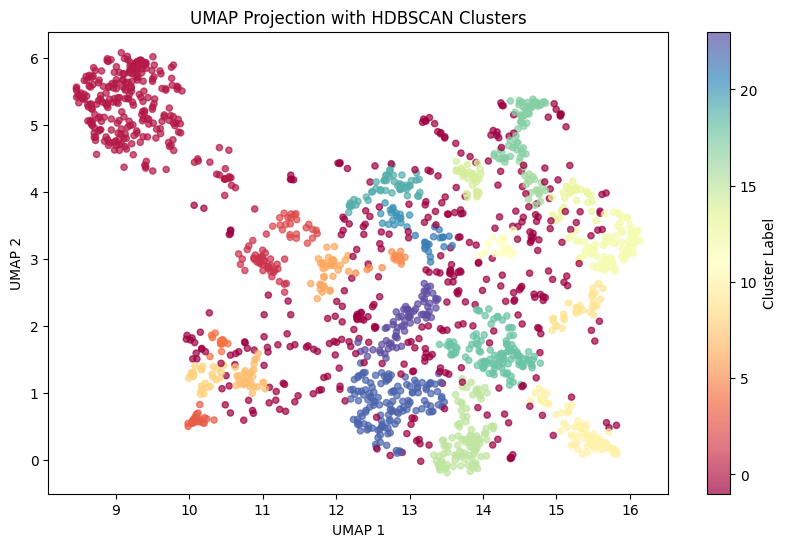

In [17]:
plt.figure(figsize=(10, 6))

plt.scatter(
    reduced_embeddings[:, 0],        
    reduced_embeddings[:, 1],       
    c=clusters,            
    cmap='Spectral',              
    s=20,                           
    alpha=0.7                      
)

plt.title("UMAP Projection with HDBSCAN Clusters")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.colorbar(label="Cluster Label")
plt.show()

In [18]:
import plotly.express as px

In [19]:
# 1. PRIORITY BAR CHART
# Count the reviews per topic
topic_counts = df1['Topic_Name'].value_counts().reset_index()
topic_counts.columns = ['Topic_Name', 'Count']

# Create the chart
fig_priority = px.bar(
    topic_counts, 
    x='Count', 
    y='Topic_Name', 
    orientation='h', # Horizontal bar chart
    title="⚠️ Top Complaint Priorities (Volume)",
    text='Count',    # Show numbers on bars
    color='Count',   # Color by severity
    color_continuous_scale='Reds',
    height=600       # Make it tall enough to read
)

# Fix the layout order
fig_priority.update_layout(yaxis={'categoryorder':'total ascending'})
fig_priority.show()

In [20]:
# 2. ANGER INTENSITY CHART
# Check if 'score' exists (in case you didn't fix Part 1)
if 'score' not in df1.columns:
    print("⚠️ 'score' column missing. Please update Cell 25 to save sentiment scores.")
    # Creating dummy scores just to show you the chart works
    df1['score'] = np.random.uniform(0.7, 0.99, size=len(df1)) 

fig_intensity = px.box(
    df1, 
    x="score", 
    y="Topic_Name", 
    color="Topic_Name",
    title="🔥 Anger Intensity (Model Confidence Score)",
    points="all",       # Show individual dots
    hover_data=["reviews.text"], # Hover to see the actual review!
    height=800
)

fig_intensity.update_layout(xaxis_title="Negativity Score (Higher = Angrier)")
fig_intensity.show()

In [22]:
# 3. ROOT CAUSE SUNBURST
# We categorize data for the chart
df_sunburst = df1.copy()
df_sunburst['Topic_Name'] = df_sunburst['Topic_Name'].replace("", "Unknown Topic")
df_sunburst['Topic_Name'] = df_sunburst['Topic_Name'].fillna("Unknown Topic")

df_sunburst['Root'] = 'Negative Reviews' # Center of the sunburst

fig_sunburst = px.sunburst(
    df_sunburst, 
    path=['Root', 'Topic_Name'], # Hierarchy: Center -> Topic
    title="🔍 Root Cause Analysis: Where are the negative reviews coming from?",
    color='Topic_Name',
    height=700
)

fig_sunburst.show()